In [1]:

from tensorflow.keras.utils import to_categorical
from PIL import Image

import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D,\
                                    GlobalMaxPool2D, Dropout, SpatialDropout2D, add, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model


from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

from tensorflow import keras
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import glob
import time
import cv2
import os

In [2]:
! gdown https://drive.google.com/u/3/uc?id=1R-Wp7HhRuQ7JVmTSwY1ZsUI7EwXtHzav

Downloading...
From: https://drive.google.com/u/3/uc?id=1R-Wp7HhRuQ7JVmTSwY1ZsUI7EwXtHzav
To: /content/PBC_dataset_normal_DIB.zip
281MB [00:02, 127MB/s]


In [3]:
! unzip -qq PBC_dataset_normal_DIB.zip

In [4]:
dir = glob.glob('PBC_dataset_normal_DIB/*')
get_freq = {}
# count = 1
for item in dir:
  freq = len(glob.glob("{}/*".format(item)))
  print(freq)
  item_name  = item.split('/')[1]
  get_freq[item_name] = freq
  #get_freq[count] = freq
  #count += 1
  #get_freq.append(freq)


1218
3329
3117
1420
1551
1214
2348
2895


In [5]:
short_index = {}
total_img_names = []
short_labels = []
for item in dir:
  img_names = glob.glob("{}/*".format(item))[:5]
  short_name = str(img_names[0].split('.')[0]).split('/')[2].split('_')[0]
  short_index[short_name] = img_names[0].split('/')[1]
  short_labels.append(short_name)
  total_img_names.append(img_names)
print(total_img_names)
print(len(total_img_names))
print(short_labels)
print(short_index)

[['PBC_dataset_normal_DIB/basophil/BA_174731.jpg', 'PBC_dataset_normal_DIB/basophil/BA_606591.jpg', 'PBC_dataset_normal_DIB/basophil/BA_68896.jpg', 'PBC_dataset_normal_DIB/basophil/BA_741421.jpg', 'PBC_dataset_normal_DIB/basophil/BA_931113.jpg'], ['PBC_dataset_normal_DIB/neutrophil/BNE_379425.jpg', 'PBC_dataset_normal_DIB/neutrophil/SNE_889334.jpg', 'PBC_dataset_normal_DIB/neutrophil/BNE_185561.jpg', 'PBC_dataset_normal_DIB/neutrophil/SNE_648057.jpg', 'PBC_dataset_normal_DIB/neutrophil/BNE_680440.jpg'], ['PBC_dataset_normal_DIB/eosinophil/EO_483350.jpg', 'PBC_dataset_normal_DIB/eosinophil/EO_166572.jpg', 'PBC_dataset_normal_DIB/eosinophil/EO_992859.jpg', 'PBC_dataset_normal_DIB/eosinophil/EO_76848.jpg', 'PBC_dataset_normal_DIB/eosinophil/EO_438160.jpg'], ['PBC_dataset_normal_DIB/monocyte/MO_902264.jpg', 'PBC_dataset_normal_DIB/monocyte/MO_998093.jpg', 'PBC_dataset_normal_DIB/monocyte/MO_666057.jpg', 'PBC_dataset_normal_DIB/monocyte/MO_905340.jpg', 'PBC_dataset_normal_DIB/monocyte/MO_19

In [6]:
short_rev_index = {}
for item in short_index:
  short_rev_index[short_index[item]] = item
print(short_rev_index)

{'basophil': 'BA', 'neutrophil': 'BNE', 'eosinophil': 'EO', 'monocyte': 'MO', 'erythroblast': 'ERB', 'lymphocyte': 'LY', 'platelet': 'PLATELET', 'ig': 'MY'}


In [7]:
index = {}
rev_index = {}
count = 0
for item in get_freq:
  index[item] = count
  rev_index[count] = item
  count += 1 
print(index)
print(rev_index)

{'basophil': 0, 'neutrophil': 1, 'eosinophil': 2, 'monocyte': 3, 'erythroblast': 4, 'lymphocyte': 5, 'platelet': 6, 'ig': 7}
{0: 'basophil', 1: 'neutrophil', 2: 'eosinophil', 3: 'monocyte', 4: 'erythroblast', 5: 'lymphocyte', 6: 'platelet', 7: 'ig'}


In [8]:
def parse_filepath(filepath):
    try:
        #path, filename = os.path.split(filepath)
        label = filepath.split('/')[1]
        #filename, ext = os.path.splitext(filename)
        #label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [9]:
DATA_DIR = 'PBC_dataset_normal_DIB'  # 302410 images. validate accuracy: 98.8%
H, W, C = 360, 360, 3
N_LABELS = len(index)
D = 1

In [10]:
files = glob.glob("{}/*/*.jpg".format(DATA_DIR))
print("Total files = ",len(files))

Total files =  17092


In [11]:
# create a pandas data frame of images, age, gender and race
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.head()

,label,file
0,basophil,PBC_dataset_normal_DIB/basophil/BA_174731.jpg
1,basophil,PBC_dataset_normal_DIB/basophil/BA_606591.jpg
2,basophil,PBC_dataset_normal_DIB/basophil/BA_68896.jpg
3,basophil,PBC_dataset_normal_DIB/basophil/BA_741421.jpg
4,basophil,PBC_dataset_normal_DIB/basophil/BA_931113.jpg


In [12]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.95)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.95)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 15425, valid count: 812, test count: 855


In [13]:
def Model_V2_Gradcam(H,W,C):

    input_layer = tf.keras.Input(shape=(H, W, C))
    x_1 = tf.keras.layers.Conv2D(16, 3, activation='relu', strides=(1, 1), name="conv_16_1", padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(input_layer)
    x_2 = tf.keras.layers.Conv2D(16, 3, activation='relu', strides=(1, 1), name="conv_16_2", padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(x_1)
    # x_4 = tf.keras.layers.Conv2D(16, 3, activation='relu', strides=(1, 1), name="conv_64_21", padding='same')(add([x_3,x_1]))
    x_3 = tf.keras.layers.MaxPooling2D((2, 2), name="max_pool3")(x_2)
    x_4 = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=(1, 1), name="conv_32_1", padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(x_3)
    x_5 = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=(1, 1), name="conv_32_2", padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(x_4)

    x_6 = tf.keras.layers.MaxPooling2D((2, 2), name="max_pool4")(x_5)
    x_7 = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=(1, 1), name="conv_64_1", padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(x_6)
    x_8 = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=(1, 1), name="conv_64_2", padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(x_7)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="max_pool5")(x_8)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=(2, 2), name="conv_64_3", kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="max_pool6")(x)
    x = tf.keras.layers.Flatten(name="flatten")(x)
    x = tf.keras.layers.Dropout(0.15, name="dropout_3")(x)
    x = tf.keras.layers.Dense(256, activation='relu', name="dense_64")(x)
    x = tf.keras.layers.Dense(N_LABELS, activation='softmax', name="output_layer")(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    return model

model = Model_V2_Gradcam(H=360, W=360, C=3)

model.compile(optimizer='adam', loss='categorical_crossentropy',
            metrics= ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
conv_16_1 (Conv2D)           (None, 360, 360, 16)      448       
_________________________________________________________________
conv_16_2 (Conv2D)           (None, 360, 360, 16)      2320      
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 180, 180, 16)      0         
_________________________________________________________________
conv_32_1 (Conv2D)           (None, 180, 180, 32)      4640      
_________________________________________________________________
conv_32_2 (Conv2D)           (None, 180, 180, 32)      9248      
_________________________________________________________________
max_pool4 (MaxPooling2D)     (None, 90, 90, 32)        0     

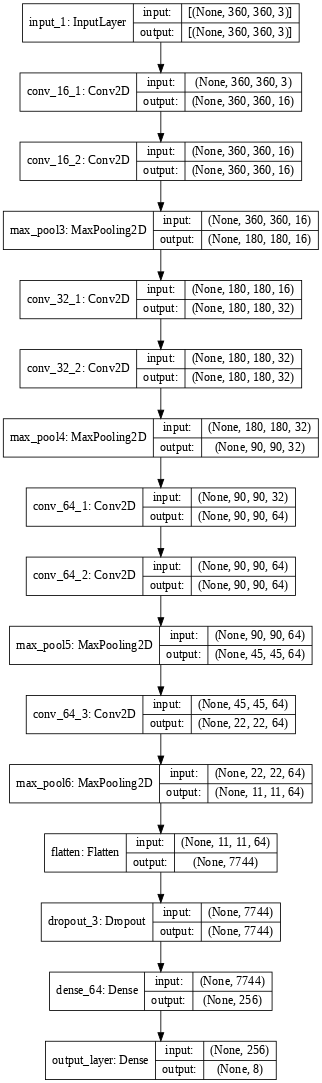

In [14]:
from tensorflow.keras.utils import  plot_model as pm  #plotting the model structure
pm(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [15]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        #print("indices = ",indices)    
        #print("len indices = ",len(indices))
        for i in indices:

            r = df.iloc[i]
            #print(" r = ", r, " i = ",i)
            file, label = r['file'], r['label']
            #print("file, label = ",file, label)
            im = Image.open(file)
            im = im.resize((360, 360))
            im = np.array(im) / 255.0
            #print(im.shape)
            images.append(im)
            #print(np.asarray([to_categorical(index[label], N_LABELS)]))
            #print(np.asarray([to_categorical(index[label], N_LABELS)]).shape)
            labels.append(to_categorical(index[label], N_LABELS))
            if len(images) >= batch_size:
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
# batch_size = 100
# valid_batch_size = 32
batch_size = 120
valid_batch_size = 120
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)
]
# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=20,
                    callbacks=[tensorboard_callback,callbacks],
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/20
128/128 [==============================] - 138s 810ms/step - loss: 1.6704 - accuracy: 0.4336 - val_loss: 0.5146 - val_accuracy: 0.8181
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 2/20
128/128 [==============================] - 101s 796ms/step - loss: 0.4675 - accuracy: 0.8509 - val_loss: 0.4150 - val_accuracy: 0.8694
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 3/20
128/128 [==============================] - 100s 784ms/step - loss: 0.3549 - accuracy: 0.8884 - val_loss: 0.3741 - val_accuracy: 0.8917
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 4/20
128/128 [==============================] - 101s 792ms/step - loss: 0.2792 - accuracy: 0.9202 - val_loss: 0.3046 - val_accuracy: 0.9153
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 5/20
128/128 [==============================] - 100s 783ms/step - loss: 0.2265 - accuracy: 0.9358 - val_loss: 0.3478 - val_accuracy: 0.8847
INFO:tensorflow:Assets wri

In [ ]:
input_1   
conv_16_1     
conv_16_2 
max_pool3     
conv_32_1   
conv_32_2     
max_pool4   
conv_64_1    
conv_64_2    
max_pool5      
conv_64_3    
max_pool6         
flatten         
dropout_3       
dense_64  
output_layer      

In [ ]:
"input_1",
"conv_16_1",     
"conv_16_2",
"max_pool3",     
"conv_32_1",   
"conv_32_2",    
"max_pool4",   
"conv_64_1",    
"conv_64_2",    
"max_pool5",      
"conv_64_3",    
"max_pool6",         
"flatten",         
"dropout_3",       
"dense_64",  
"output_layer"

In [27]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'history_classification_model_v2_20e.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

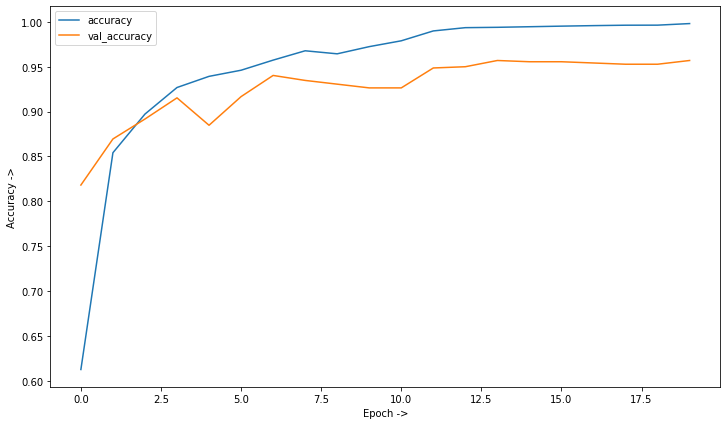

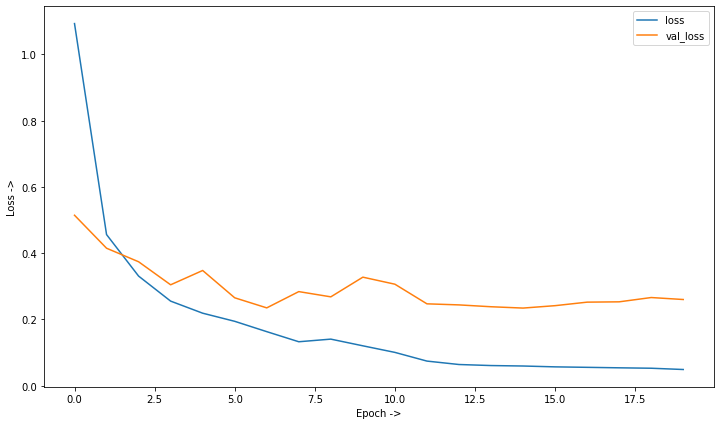

In [28]:
plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['accuracy']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()

In [29]:
# download the model in computer for later use
model.save('classification_model_v2_blood_20epochs.h5')

In [30]:
from tensorflow import keras
model = keras.models.load_model('classification_model_v2_blood_20epochs.h5')

In [31]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

6/6 [==============================] - 5s 703ms/step - loss: 0.2118 - accuracy: 0.9622


{'accuracy': 0.9622395634651184, 'loss': 0.21177835762500763}

In [32]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

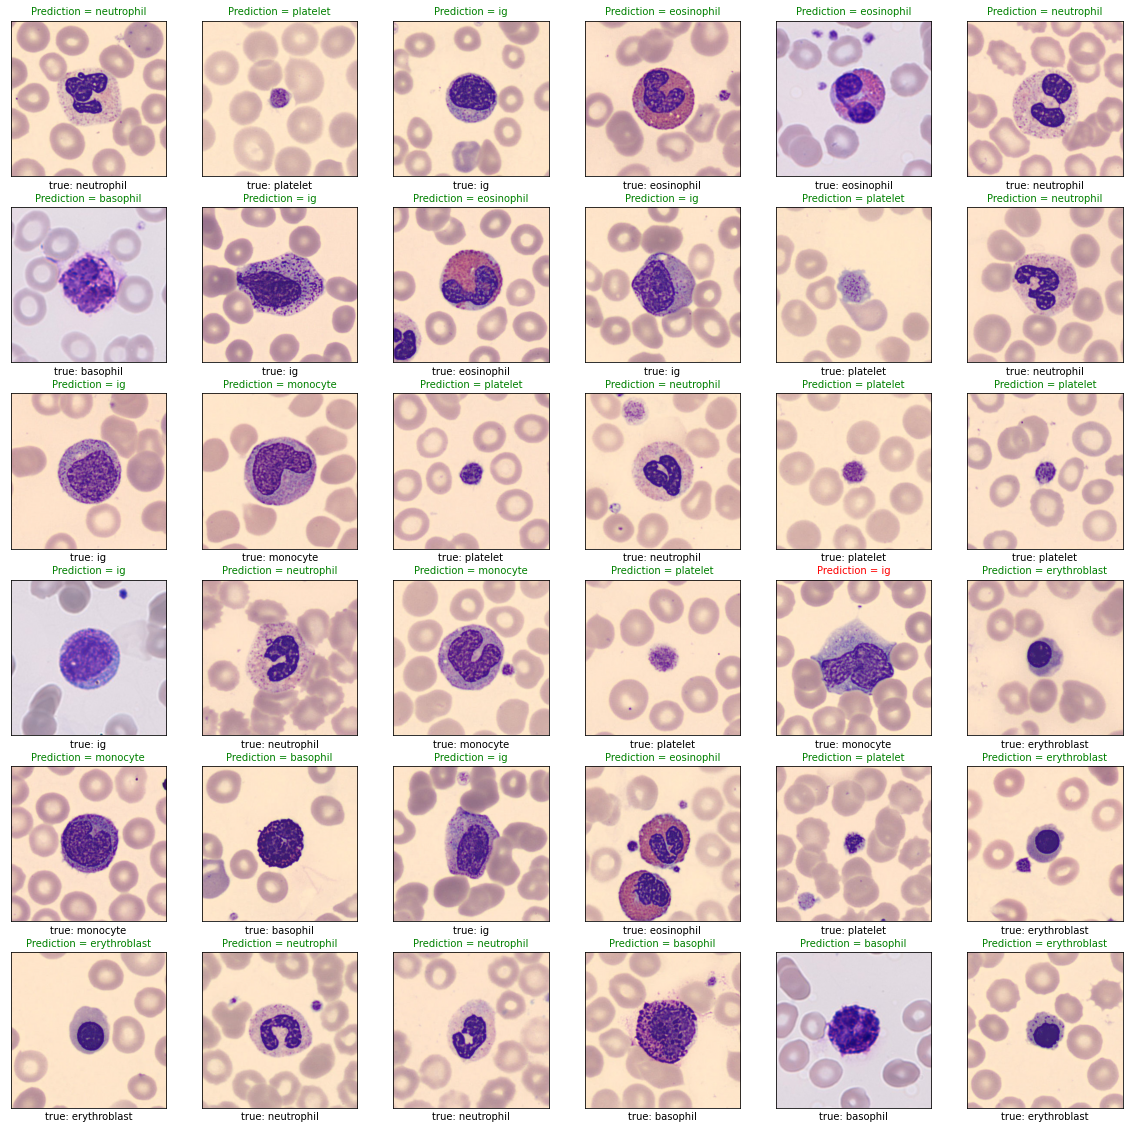

In [33]:
import math
n = 36
random_indices = np.random.permutation(n)
n_cols = 6
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    img_ = x_test[img_idx].copy()
    ax.imshow(img_)
    actual_pred = ""
    true_val = ""
    actual_pred = rev_index[int(y_pred[img_idx])]
    true_val = rev_index[int(y_true[img_idx])]
    if actual_pred == true_val:
        ax.set_title("Prediction = {}".format(actual_pred),fontsize=10).set_color('green')
    else:
        ax.set_title("Prediction = {}".format(actual_pred),fontsize=10).set_color('red')
    ax.set_xlabel('true: {}'.format(true_val),fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
input_9                                      
conv_32           
conv_64
concatenate_17                  
conv_64_2              
max_pool3                  
conv_64_3                 
conv_64_31                
concatenate_18                  
conv_64_32             
max_pool4                
conv_64_4                  
conv_64_41                  
concatenate_19                  
conv_64_42             
max_pool5 
conv_64_5 
max_pool6 
flatten 
dropout_3 
dense_64 
output_layer 

In [ ]:
# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    last_conv_layer_model.summary()

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

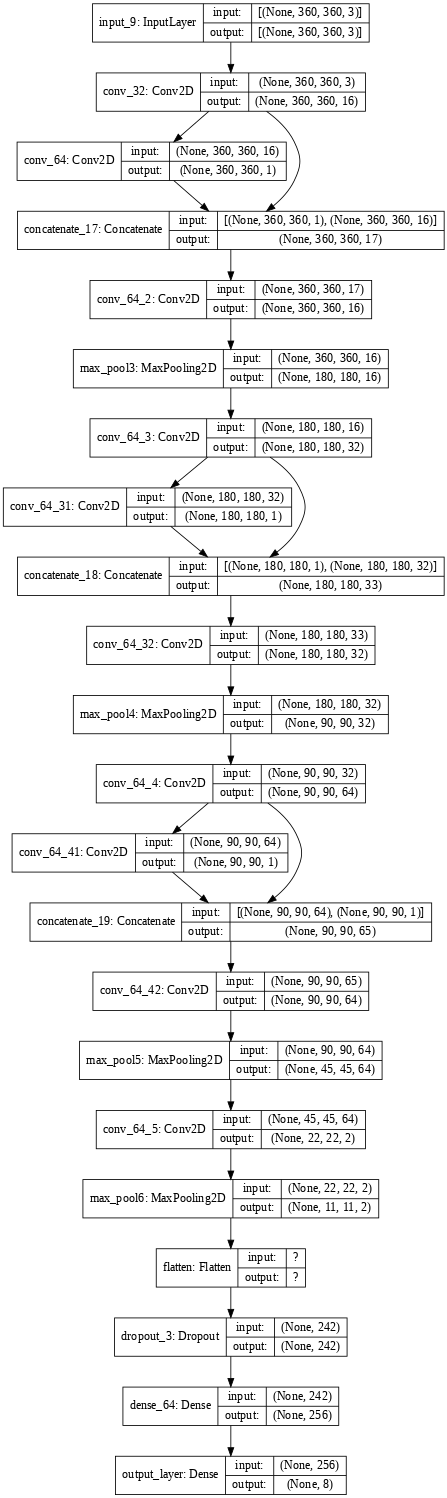

In [ ]:
from tensorflow.keras.utils import  plot_model as pm  #plotting the model structure
pm(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [ ]:

# Prepare image
#img_array = preprocess_input(get_img_array(img_path, size=img_size))


img_array = np.expand_dims(x_test[0], axis=0)
print(img_array.shape)
# Make model
# model = model_builder(weights="imagenet")

# Print what the top predicted class is
preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])
print("preds : ", preds)

                                      


last_conv_layer_name = "conv_64"
classifier_layer_names = [      
    "concatenate_17", 
    "conv_64_2",              
    "max_pool3",                  
    "conv_64_3",                
    "conv_64_31",                
    "concatenate_18",                  
    "conv_64_32",             
    "max_pool4",                
    "conv_64_4",                  
    "conv_64_41",                  
    "concatenate_19",                  
    "conv_64_42",             
    "max_pool5", 
    "conv_64_5", 
    "max_pool6", 
    "flatten", 
    "dropout_3", 
    "dense_64", 
    "output_layer", 
]


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
# plt.matshow(heatmap)
# plt.show()


(1, 360, 360, 3)
preds :  [[5.7032428e-16 1.0479534e-33 0.0000000e+00 1.0243782e-23 1.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]]
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 360, 360, 3)]     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


ValueError: ignored

In [ ]:
# We load the original image
# img = keras.preprocessing.image.load_img(img_path)
# img = keras.preprocessing.image.img_to_array(img)

img = x_test[0]

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "cell.jpg"
superimposed_img.save(save_path)


In [ ]:
# Display Grad CAM
#display(Image(save_path))
fig = plt.figure(figsize=(10,30))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(x_test[0])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(heatmap)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(superimposed_img)